In [3]:
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD

In [10]:
start = UTCDateTime("2020-03-10")
end = UTCDateTime("2020-04-08") # means "now"

network = "AU"
station = "PHB"
location = "00"
channel = "SHZ"
dataset = "Parliament"

data_provider = "IRIS"
logo = None #plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png')
bans = {"2020-03-18":'Groups >100 banned', 
        "2020-03-24":'Restaurants and Schools Closed'}

In [11]:
datelist = pd.date_range(start.datetime, end.datetime, freq="D")
c = Client(data_provider)

nslc = "{}.{}.{}.{}".format(network, station, location, channel)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")
for day in datelist:
    datestr = day.strftime("%Y-%m-%d")
    fn = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    print(fn)
    if day != datelist[-1] and os.path.isfile(fn):
        continue
    else:
        st = c.get_waveforms(network, station, location, channel,
                             UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801, attach_response=True)
        print(st)
        st.write(fn)
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
print(resp)


test_2020-03-10_AU.PHB.00.Z.mseed
2 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-09T23:29:59.040000Z - 2020-03-11T00:30:00.990000Z | 20.0 Hz, 1800040 samples
AU.PHB.00.SHZ | 2020-03-09T23:29:59.040000Z - 2020-03-11T00:30:00.990000Z | 20.0 Hz, 1800040 samples
test_2020-03-11_AU.PHB.00.Z.mseed
2 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-10T23:29:59.040000Z - 2020-03-12T00:30:00.990000Z | 20.0 Hz, 1800040 samples
AU.PHB.00.SHZ | 2020-03-10T23:29:59.040000Z - 2020-03-12T00:30:00.990000Z | 20.0 Hz, 1800040 samples
test_2020-03-12_AU.PHB.00.Z.mseed
2 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-11T23:29:59.040000Z - 2020-03-13T00:30:00.990000Z | 20.0 Hz, 1800040 samples
AU.PHB.00.SHZ | 2020-03-11T23:29:59.040000Z - 2020-03-13T00:30:00.990000Z | 20.0 Hz, 1800040 samples
test_2020-03-13_AU.PHB.00.Z.mseed
2 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-12T23:29:59.040000Z - 2020-03-14T00:30:00.990000Z | 20.0 Hz, 1800040 samples
AU.PHB.00.SHZ | 2020-03-12T23:29:59.040000Z - 2020-03-14T00:30:00.990

## Step 4: Compute PPSDs using custom parameters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [12]:
for day in datelist:
    datestr = day.strftime("%Y-%m-%d")
    fn_in = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    if day == datelist[-1] :
        continue
    stall = read(fn_in)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = "{}_{}_{}.npz".format(dataset, datestr, mseedid)
        if os.path.isfile(fn_out):
            print("%s done already."%fn_out)
            continue
        st = stall.select(id=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        print(st)
        del st, ppsd
    del stall


/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:998: RuntimeWarning: Mean of empty slice.
  smoothed_psd.append(specs.mean())
/opt/anaconda3/envs/covid/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 Trace(s) in Stream:
AU.PHB.00.SHZ | 2020-03-09T23:29:59.040000Z - 2020-03-11T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-09T23:29:59.040000Z - 2020-03-11T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.SHZ | 2020-03-10T23:29:59.040000Z - 2020-03-12T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-10T23:29:59.040000Z - 2020-03-12T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.SHZ | 2020-03-11T23:29:59.040000Z - 2020-03-13T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-11T23:29:59.040000Z - 2020-03-13T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.SHZ | 2020-03-12T23:29:59.040000Z - 2020-03-14T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in Stream:
AU.PHB.00.BNZ | 2020-03-12T23:29:59.040000Z - 2020-03-14T00:30:00.990000Z | 20.0 Hz, 1800040 samples
1 Trace(s) in St

## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [13]:
ppsds = {}
for day in datelist:
    datestr = day.strftime("%Y-%m-%d")
    fn_pattern = "{}_{}_*.npz".format(dataset, datestr)
    for fn in glob(fn_pattern):
        mseedid = fn.replace(".npz", "").split("_")[-1]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn, allow_pickle=True)
        else:
            ppsds[mseedid].add_npz(fn, allow_pickle=True)
            
            


/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'test_2020-03-11_AU.PHB.00.BNZ.npz' (time ranges already covered).
  warnings.warn(msg)
/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'test_2020-03-11_AU.PHB.00.SHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1510: UserWarning: Mismatch in version numbers (ppsd_version) between current data (3) and loaded data (1).
  warnings.warn(msg)
/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'test_2020-03-11_S1.AUKSC..BHZ.npz' (time ranges already covered).
  warnings.warn(msg)
/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: User

## Step 6: Standard plots:


/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:2096: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(*fig.ppsd.color_limits)


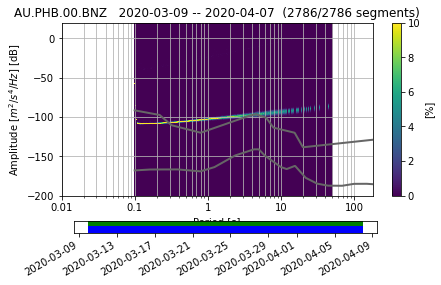

/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:2096: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(*fig.ppsd.color_limits)


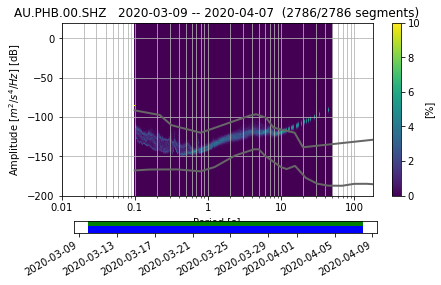

/opt/anaconda3/envs/covid/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:2096: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(*fig.ppsd.color_limits)


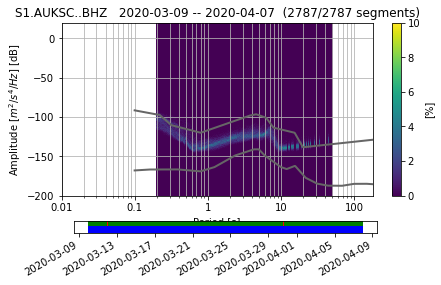

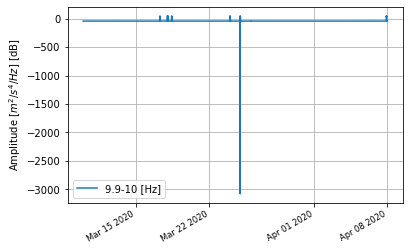

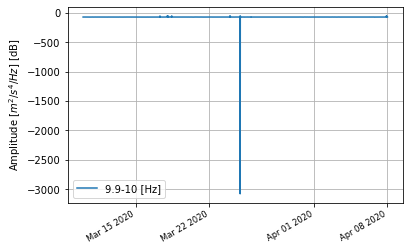

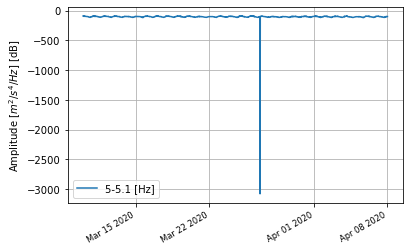

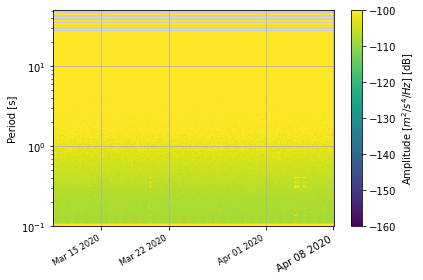

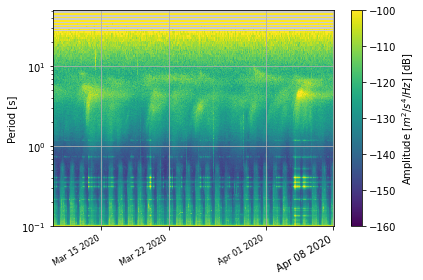

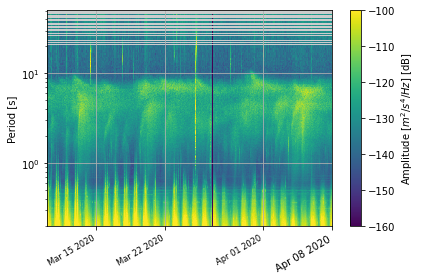

[None, None, None]

In [14]:
[ppsd.plot(max_percentage=10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_spectrogram(clim=(-160,-100)) for mseedid, ppsd in ppsds.items()]

#### Step 7: Process PSDs to extract the RMS(displacement)
This can be done for multiple filters at once (freqs below):

In [15]:
# Define frequency bands of interest:
freqs = [(0.5,10.0),(4.0,10.0),(2.0,10.0),(4.0,14.0)]


def rms(s, f):
    # Parseval: the RMS in time domain is the sqrt of the integral of the power spectrum
    return np.sqrt(np.trapz(s, f))

displacement_RMS = {}
for mseedid, ppsd in ppsds.items():
    per = ppsd.period_bin_centers
    displacement_RMS[mseedid] = []
    for psd in ppsd.psd_values:
        RMS = {}
        for fmin, fmax in freqs:
            ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

            # acceleration power spectrum in Hz
            spec = psd.copy()[ix][::-1]
            f = 1.0/per.copy()[ix][::-1]

            # remove NaNs from the list
            valid = np.where(np.isfinite(spec))[0]
            spec = spec[valid]
            f = f[valid]

            w2f = (2.0 * np.pi * f)

            # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
            amp = 10.0**(spec/10.) 

            # velocity spectrum (divide by omega**2)
            vamp = amp / w2f**2

            # displacement spectrum (divide by omega**2)
            damp =  vamp / w2f**2

            RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)

        displacement_RMS[mseedid].append(RMS)
        index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
    displacement_RMS[mseedid] = pd.DataFrame(displacement_RMS[mseedid], index=index)
    print(mseedid," rms done.")

AU.PHB.00.BNZ  rms done.
AU.PHB.00.SHZ  rms done.
S1.AUKSC..BHZ  rms done.


## Step 8: Custom plot for a single frequency band:

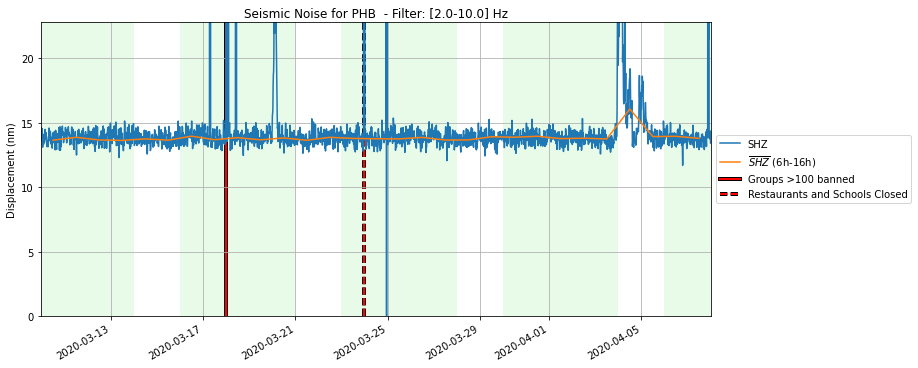

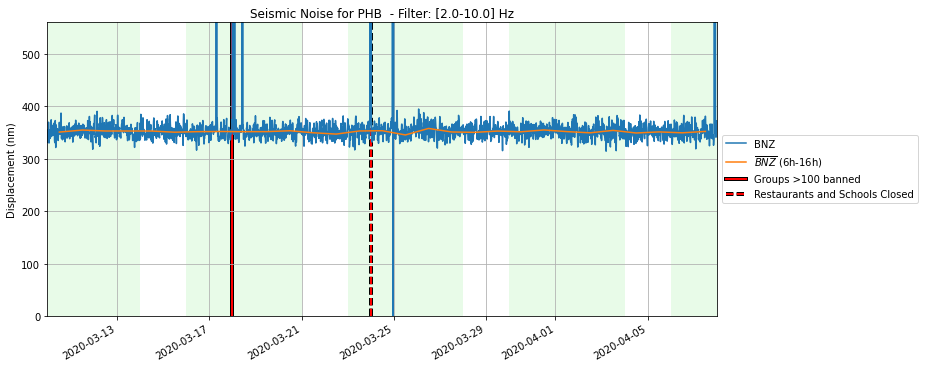

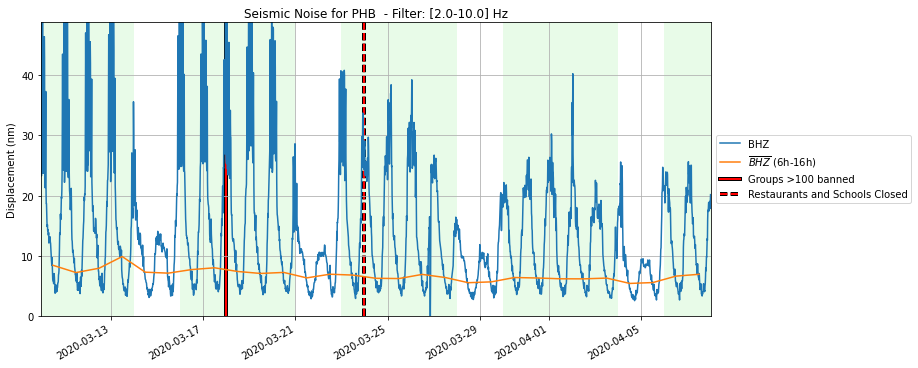

In [16]:
band = "2.0-10.0"

for channelcode in list(set([k[:-1] for k in displacement_RMS])):
    fig = plt.figure(figsize=(12,6))
    if logo is not None:
        fig.figimage(logo, 40, 40, alpha=.4, zorder=1, resize=True)
    data={}
    for o in 'ZEN':
        if channelcode+o not in displacement_RMS :
            continue
        data[channelcode[-2:]+o] = displacement_RMS[channelcode+o][band]
        main=channelcode[-2:]+o
        
    if len(data.keys())>1:
        data[channelcode[-2:]+'*'] = data[main].copy() # for the sum
        main=channelcode[-2:]+'*'
        for i,t in enumerate(data[main].index):        
            data[main][i] = 0
            for o in data:
                if o == main:
                    continue
                if len(data[o].index)-1<i:
                    break
                if abs(data[o].index[i].timestamp()-data[main].index[i].timestamp())<60:
                    data[main][i] += data[o][i]**2
            data[main][i] = data[main][i]**.5
    
    plt.plot(data[main].index, data[main], label = main)
    
    for o in data:
        rs = data[o].copy().between_time("6:00", "16:00")
        rs = rs.resample("1D" ).median().tshift(12, "H")
        plt.plot(rs.index, rs, 
                 label="$\overline{%s}$ (6h-16h)"%o)#, c='purple')

    

    # Get normal business days and set their background color to green
    db = pd.bdate_range(start.datetime, end.datetime)
    for dbi in db:
        plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                    facecolor='lightgreen', edgecolor="none",
                    alpha=0.2, zorder=-10)

    scale = 1e9
    plt.ylim(0,np.percentile(data[main],95)*1.5)
    ticks = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x*scale))
    plt.gca().yaxis.set_major_formatter(ticks)
    plt.ylabel("Displacement (nm)")

    plt.title('Seismic Noise for %s  - Filter: [%s] Hz' % (station, band))
    plt.xlim(data[main].index.min(), data[main].index.max())
    fig.autofmt_xdate()
    plt.grid(True, zorder=-1)
    plt.gca().set_axisbelow(True)    
    for iban,ban in enumerate(bans.keys()):
        plt.axvline(UTCDateTime(ban).datetime,
                    color='r', 
                    linewidth=2,
                    linestyle=['-', '--', '-.', ':'][iban],
                    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
                    zorder=-9,
                    label=bans[ban])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    fig.savefig(channelcode+".pdf",bbox_inches='tight')
    fig.savefig(channelcode+".png",bbox_inches='tight')